In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    hamming_loss,
    jaccard_score,
)
import os
from tensorflow.keras.callbacks import ModelCheckpoint

Data preparation

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
movie_dataset = pd.read_csv("/content/drive/MyDrive/semestr 9/movie_dataset_prepared.csv")

In [6]:
movie_dataset.head()

movie_dataset

,genres_list,keywords_list,overview
0,"[28, 12, 14, 878]","[2964, 3801, 9840, 9882, 9951, 13065, 14643, 2...",in the 22nd century a paraplegic marine is dis...
1,"[12, 14, 28]","[2038, 3799, 179430]",captain barbossa long believed to be dead has ...
2,"[28, 12, 80]","[470, 818, 4289, 9663]",a cryptic message from bonds past sends him on...
3,"[28, 80, 18, 53]","[849, 949, 1308, 9715, 156395]",following the death of district attorney harve...
4,"[28, 12, 878]","[818, 3801, 7376, 9951, 10685, 207928, 209714]",john carter is a warweary former military capt...
...,...,...,...
4795,"[28, 80, 53]",[],el mariachi just wants to play his guitar and ...
4796,"[35, 10749]",[],a newlywed couples honeymoon is upended by the...
4797,"[35, 18, 10749, 10770]",[5340],signed sealed delivered introduces a dedicated...
4798,[],[],when ambitious new york attorney sam is sent t...


In [7]:
all_genres = [g for g_list in movie_dataset["genres_list"] for g in g_list]
g_counts = Counter(all_genres)

frequent_genres = {g for g, count in g_counts.items() if count > 150}

movie_dataset["genres_list"] = movie_dataset["genres_list"].apply(
    lambda lst: [g for g in lst if g in frequent_genres]
)


In [8]:
# metod for oversampling imbalanced data

def oversample_multilabel_multitask(X, y, target_strategy="max", random_state=42):
    """
    Prosty oversampling dla multi-label:
    - X: np.array (n_samples, max_len)
    - y: np.array (n_samples, n_classes) z wartościami 0/1
    - target_strategy:
        "max"  -> każdą etykietę dociągamy do max liczności
        "mean" -> dociągamy do średniej liczności etykiet
    Zwraca: X_bal, y_bal
    """
    rng = np.random.default_rng(random_state)


    label_counts = y.sum(axis=0).astype(int)
    if target_strategy == "max":
        target = label_counts.max()
    elif target_strategy == "mean":
        target = int(label_counts.mean())
    else:
        raise ValueError("target_strategy must be 'max' or 'mean'")

    n_classes = y.shape[1]


    idx_per_label = {
        c: np.where(y[:, c] == 1)[0]
        for c in range(n_classes)
    }

    # X_list = [X]
    # y_list = [y]
    selected_idx = list(range(len(X)))


    for c in range(n_classes):
        deficit = target - label_counts[c]
        if deficit <= 0:
            continue


        candidate_idx = idx_per_label[c]
        if len(candidate_idx) == 0:
            continue


        sampled_idx = rng.choice(candidate_idx, size=deficit, replace=True)
        selected_idx.extend(sampled_idx.tolist())

    selected_idx = np.array(selected_idx, dtype=int)
    perm = rng.permutation(len(selected_idx))
    selected_idx = selected_idx[perm]


    X_bal = X[selected_idx]
    y_bal = y[selected_idx]

    return X_bal, y_bal, selected_idx

--- Sequence Length Statistics ---
Mean length: 51.98 words
Max length: 175 words
------------------------------
90% of descriptions fit in: 85 words
95% of descriptions fit in: 107 words  <-- RECOMMENDED FOR MAX_LEN
98% of descriptions fit in: 129 words


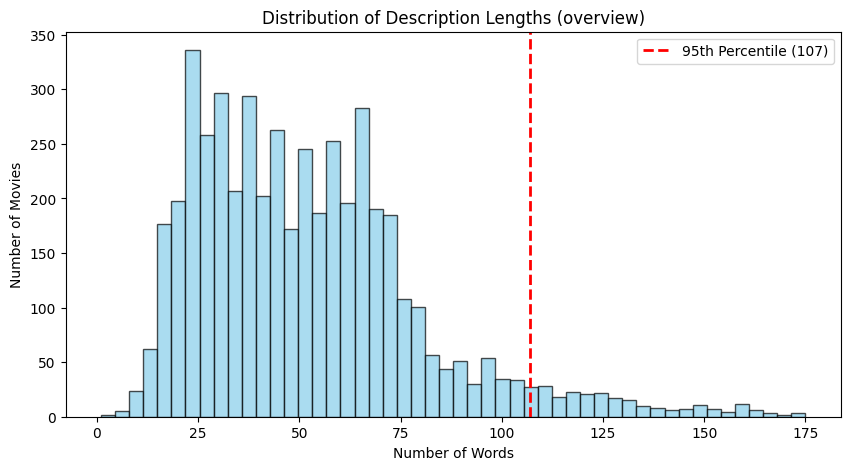

In [9]:
# defining max_len value for lstm

# 1. Calculate sequence lengths
seq_lengths = [len(str(text).split()) for text in movie_dataset['overview']]


# 2. Calculate percentiles
p90 = np.percentile(seq_lengths, 90)
p95 = np.percentile(seq_lengths, 95)
p98 = np.percentile(seq_lengths, 98)
max_val = np.max(seq_lengths)

# 3. Print results
print(f"--- Sequence Length Statistics ---")
print(f"Mean length: {np.mean(seq_lengths):.2f} words")
print(f"Max length: {max_val} words")
print(f"-" * 30)
print(f"90% of descriptions fit in: {int(p90)} words")
print(f"95% of descriptions fit in: {int(p95)} words  <-- RECOMMENDED FOR MAX_LEN")
print(f"98% of descriptions fit in: {int(p98)} words")

# 4. Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(seq_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(p95, color='red', linestyle='dashed', linewidth=2, label=f'95th Percentile ({int(p95)})')
plt.title('Distribution of Description Lengths (overview)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Movies')
plt.legend()
plt.show()

In [10]:
#createing small dataset for testing purposes

# movie_dataset_small = movie_dataset.sample(n=100, random_state=42)

# movie_dataset = movie_dataset_small

# movie_dataset.head()

In [11]:
# tokenazation and padding for overwiew
movie_dataset['overview'] = movie_dataset['overview'].fillna('').astype(str)


# checking the number of unique words to better estimate size of the vocabulary (max_features)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(movie_dataset['overview'])
print("Unique words:", len(tokenizer.word_index))

Unique words: 23598


In [12]:
max_features = 20000
max_len = 128
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(movie_dataset['overview'].values)
X = tokenizer.texts_to_sequences(movie_dataset['overview'].values)
X = pad_sequences(X, max_len)

In [13]:
# multi-label binarization

mlb_genres = MultiLabelBinarizer()
y_genres = mlb_genres.fit_transform(movie_dataset["genres_list"])
genres_classes = mlb_genres.classes_
num_genres_classes = len(genres_classes)

mlb_keywords = MultiLabelBinarizer()
y_keywords = mlb_keywords.fit_transform(movie_dataset["keywords_list"])
keywords_classes = mlb_keywords.classes_
num_keywords_classes = len(keywords_classes)

In [14]:
y_for_split = np.argmax(y_genres, axis=1)
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

Manually specified (non-default) hyperparameters of the model architecture:

- input_dim=10000 - sice of the vocabulary (based on the number of unique words)  
- output_dim=100 - length of embeding vector, value 100 is commonly use for the model. It was not tunned because of it low impact on model and to reduce computatino time  
- Dense(64, activation='relu') – a dense layer with ReLU activation (it allowes model to lern more complex representatinos)  
- Dense(num_classes, activation='sigmoid') - defining how many class we have, sigmoid for multi-label classification
- Nr of epochs - 15 (with early dtop added)

The parameters we will be tuning:

- the number of LSTM units  
- dropout - to reduce overfitting

In [15]:
def create_multitask_model(lstm_units, dropout_rate, num_genres_classes, num_keywords_classes, max_features, max_len):
    """Create Bidirectional LSTM model with two outputs"""

    # Input layer
    input_layer = Input(shape=(max_len,))

    # Shared embedding and LSTM layers
    embedding = Embedding(input_dim=max_features, output_dim=100)(input_layer)
    lstm1 = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
    dropout1 = Dropout(dropout_rate)(lstm1)
    lstm2 = Bidirectional(LSTM(lstm_units // 2))(dropout1)
    dropout2 = Dropout(dropout_rate)(lstm2)
    shared = Dense(64, activation='relu')(dropout2)
    shared = Dropout(dropout_rate)(shared)

    # Output for genres
    genres_output = Dense(num_genres_classes, activation='sigmoid', name='genres')(shared)

    # Output for keywords
    keywords_output = Dense(num_keywords_classes, activation='sigmoid', name='keywords')(shared)

    # Create model with two outputs
    model = Model(inputs=input_layer, outputs=[genres_output, keywords_output])

    model.compile(
        loss={
            'genres': 'binary_crossentropy',
            'keywords': 'binary_crossentropy'
        },
        optimizer=Adam(learning_rate=3e-4),
        metrics={
            'genres': ['accuracy'],
            'keywords': ['accuracy']
        }
    )
    return model

In [16]:
SAVE_MODEL_DIR = "/content/drive/MyDrive/lstm_genres_and_keywords/models_4"
os.makedirs(SAVE_MODEL_DIR, exist_ok=True)

RESULTS_DIR = "/content/drive/MyDrive/lstm_genres_and_keywords/results_4"
os.makedirs(RESULTS_DIR, exist_ok=True)

param_grid = list(ParameterGrid({
    'lstm_units': [64, 128],
    'dropout_rate': [0.3, 0.5],
}))

fold_results = []
metrics_all = {
    # GENRES
    'accuracy_g': {str(p): [] for p in param_grid},
    'precision_g': {str(p): [] for p in param_grid},
    'recall_g': {str(p): [] for p in param_grid},
    'f1_g': {str(p): [] for p in param_grid},
    'hamming_loss_g': {str(p): [] for p in param_grid},
    'hamming_accuracy_g': {str(p): [] for p in param_grid},
    'f1_macro_g': {str(p): [] for p in param_grid},
    'f1_micro_g': {str(p): [] for p in param_grid},
    'jaccard_samples_g': {str(p): [] for p in param_grid},

    # KEYWORDS
    'accuracy_k': {str(p): [] for p in param_grid},
    'precision_k': {str(p): [] for p in param_grid},
    'recall_k': {str(p): [] for p in param_grid},
    'f1_k': {str(p): [] for p in param_grid},
    'hamming_loss_k': {str(p): [] for p in param_grid},
    'hamming_accuracy_k': {str(p): [] for p in param_grid},
    'f1_macro_k': {str(p): [] for p in param_grid},
    'f1_micro_k': {str(p): [] for p in param_grid},
    'jaccard_samples_k': {str(p): [] for p in param_grid},

    # COMBINED (ranking parametrów)
    'f1_combined': {str(p): [] for p in param_grid},
    'f1_macro_combined': {str(p): [] for p in param_grid},
    'jaccard_combined': {str(p): [] for p in param_grid},
}

predictions_all = {
    str(p): {
        'genres_true': [], 'genres_pred': [],
        'keywords_true': [], 'keywords_pred': []
    }
    for p in param_grid
}

# Grid Search with Cross-Validation
print("Starting Grid Search with Cross-Validation...\n")
print(f"Total combinations: {len(param_grid)}")
print(f"Total folds per combination: {n_splits}")
print(f"Total models to train: {len(param_grid) * n_splits}")
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

results_file = 'grid_search_results.json'


for param_idx, params in enumerate(param_grid):
  p_str = str(params)

  print("="*80)
  print(f"COMBINATION {param_idx + 1}/{len(param_grid)}")
  print("="*80)
  print(f"Parameters: {params}")
  print(f"Started at: {datetime.now().strftime('%H:%M:%S')}")
  print("-"*80)

  for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_for_split)):
    print(f"\n  FOLD {fold + 1}/{n_splits}")
    print(f"  Training samples: {len(train_idx)}, Validation samples: {len(val_idx)}")


    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_genres_train_fold, y_genres_val_fold = y_genres[train_idx], y_genres[val_idx]
    y_keywords_train_fold, y_keywords_val_fold = y_keywords[train_idx], y_keywords[val_idx]


    X_train_fold, y_genres_train_fold, idx = oversample_multilabel_multitask(
      X_train_fold,
      y_genres_train_fold,
      target_strategy="mean",
      random_state=42
    )
    y_keywords_train_fold = y_keywords_train_fold[idx]



    model = create_multitask_model(
            lstm_units=params['lstm_units'],
            dropout_rate=params['dropout_rate'],
            num_genres_classes=num_genres_classes,
            num_keywords_classes=num_keywords_classes,
            max_features=max_features,
            max_len = max_len
        )

    model_name = (
        f"lstm_units{params['lstm_units']}_"
        f"drop{params['dropout_rate']}_"
        f"fold{fold+1}.keras"
    )
    checkpoint_path = os.path.join(SAVE_MODEL_DIR, model_name)


    early_stop = EarlyStopping(
            monitor='val_loss',
            patience=6,
            restore_best_weights=True,
            verbose=0
        )

    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    print(f"  Training...")
    history = model.fit(
    X_train_fold,
    {
        'genres': y_genres_train_fold,
        'keywords': y_keywords_train_fold
    },
    validation_data=(
        X_val_fold,
        {
            'genres': y_genres_val_fold,
            'keywords': y_keywords_val_fold
        }
    ),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

    # Show training summary
    final_epoch = len(history.history['loss'])
    print(f"\n  Completed {final_epoch} epochs (early stopped: {final_epoch < 15})")
    print(f"  Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"  Final validation loss: {history.history['val_loss'][-1]:.4f}")
    print(f"  Best validation loss: {min(history.history['val_loss']):.4f}")

    y_pred_genres_probs, y_pred_keywords_probs = model.predict(X_val_fold, verbose=0)

    y_pred_genres = (y_pred_genres_probs > 0.5).astype(int)
    y_pred_keywords = (y_pred_keywords_probs > 0.3).astype(int)


    predictions_all[p_str]['genres_true'].extend(y_genres_val_fold)
    predictions_all[p_str]['genres_pred'].extend(y_pred_genres)
    predictions_all[p_str]['keywords_true'].extend(y_keywords_val_fold)
    predictions_all[p_str]['keywords_pred'].extend(y_pred_keywords)

    acc_g = accuracy_score(y_genres_val_fold, y_pred_genres)
    prec_g = precision_score(y_genres_val_fold, y_pred_genres, average='samples', zero_division=0)
    rec_g = recall_score(y_genres_val_fold, y_pred_genres, average='samples', zero_division=0)
    f1_g = f1_score(y_genres_val_fold, y_pred_genres, average='samples', zero_division=0)
    h_loss_g = hamming_loss(y_genres_val_fold, y_pred_genres)
    h_acc_g = 1.0 - h_loss_g
    f1_macro_g = f1_score(y_genres_val_fold, y_pred_genres, average='macro', zero_division=0)
    f1_micro_g = f1_score(y_genres_val_fold, y_pred_genres, average='micro', zero_division=0)
    jacc_g = jaccard_score(y_genres_val_fold, y_pred_genres, average='samples', zero_division=0)

    acc_k = accuracy_score(y_keywords_val_fold, y_pred_keywords)
    prec_k = precision_score(y_keywords_val_fold, y_pred_keywords, average='samples', zero_division=0)
    rec_k = recall_score(y_keywords_val_fold, y_pred_keywords, average='samples', zero_division=0)
    f1_k = f1_score(y_keywords_val_fold, y_pred_keywords, average='samples', zero_division=0)
    h_loss_k = hamming_loss(y_keywords_val_fold, y_pred_keywords)
    h_acc_k = 1.0 - h_loss_k
    f1_macro_k = f1_score(y_keywords_val_fold, y_pred_keywords, average='macro', zero_division=0)
    f1_micro_k = f1_score(y_keywords_val_fold, y_pred_keywords, average='micro', zero_division=0)
    jacc_k = jaccard_score(y_keywords_val_fold, y_pred_keywords, average='samples', zero_division=0)

    f1_combined = (f1_g + f1_k) / 2.0
    f1_macro_combined = (f1_macro_g + f1_macro_k) / 2.0
    jacc_combined = (jacc_g + jacc_k) / 2.0


    metrics_all['accuracy_g'][p_str].append(acc_g)
    metrics_all['precision_g'][p_str].append(prec_g)
    metrics_all['recall_g'][p_str].append(rec_g)
    metrics_all['f1_g'][p_str].append(f1_g)
    metrics_all['hamming_loss_g'][p_str].append(h_loss_g)
    metrics_all['hamming_accuracy_g'][p_str].append(h_acc_g)
    metrics_all['f1_macro_g'][p_str].append(f1_macro_g)
    metrics_all['f1_micro_g'][p_str].append(f1_micro_g)
    metrics_all['jaccard_samples_g'][p_str].append(jacc_g)

    metrics_all['accuracy_k'][p_str].append(acc_k)
    metrics_all['precision_k'][p_str].append(prec_k)
    metrics_all['recall_k'][p_str].append(rec_k)
    metrics_all['f1_k'][p_str].append(f1_k)
    metrics_all['hamming_loss_k'][p_str].append(h_loss_k)
    metrics_all['hamming_accuracy_k'][p_str].append(h_acc_k)
    metrics_all['f1_macro_k'][p_str].append(f1_macro_k)
    metrics_all['f1_micro_k'][p_str].append(f1_micro_k)
    metrics_all['jaccard_samples_k'][p_str].append(jacc_k)

    metrics_all['f1_combined'][p_str].append(f1_combined)
    metrics_all['f1_macro_combined'][p_str].append(f1_macro_combined)
    metrics_all['jaccard_combined'][p_str].append(jacc_combined)


    print(f"\n  FOLD {fold + 1} RESULTS:")
    print(f"    GENRES   | Acc: {acc_g:.4f}  Prec(s): {prec_g:.4f}  Rec(s): {rec_g:.4f}  F1(s): {f1_g:.4f}  H-Acc: {h_acc_g:.4f}  Jacc: {jacc_g:.4f}")
    print(f"    KEYWORDS | Acc: {acc_k:.4f}  Prec(s): {prec_k:.4f}  Rec(s): {rec_k:.4f}  F1(s): {f1_k:.4f}  H-Acc: {h_acc_k:.4f}  Jacc: {jacc_k:.4f}")
    print(f"    COMBINED | F1(avg): {f1_combined:.4f}  Jacc(avg): {jacc_combined:.4f}  F1_macro(avg): {f1_macro_combined:.4f}")

    fold_results.append({
        'params': params,
        'fold': fold + 1,

        'genres_accuracy': float(acc_g),
        'genres_precision_samples': float(prec_g),
        'genres_recall_samples': float(rec_g),
        'genres_f1_samples': float(f1_g),
        'genres_hamming_loss': float(h_loss_g),
        'genres_hamming_accuracy': float(h_acc_g),
        'genres_f1_macro': float(f1_macro_g),
        'genres_f1_micro': float(f1_micro_g),
        'genres_jaccard_samples': float(jacc_g),

        'keywords_accuracy': float(acc_k),
        'keywords_precision_samples': float(prec_k),
        'keywords_recall_samples': float(rec_k),
        'keywords_f1_samples': float(f1_k),
        'keywords_hamming_loss': float(h_loss_k),
        'keywords_hamming_accuracy': float(h_acc_k),
        'keywords_f1_macro': float(f1_macro_k),
        'keywords_f1_micro': float(f1_micro_k),
        'keywords_jaccard_samples': float(jacc_k),

        'f1_combined': float(f1_combined),
        'f1_macro_combined': float(f1_macro_combined),
        'jaccard_combined': float(jacc_combined),


        'epochs_trained': int(final_epoch),
        'final_train_loss': float(history.history['loss'][-1]),
        'final_val_loss': float(history.history['val_loss'][-1]),
    })


  avg_f1_g = np.mean(metrics_all['f1_g'][p_str])
  avg_f1_k = np.mean(metrics_all['f1_k'][p_str])
  avg_f1_comb = np.mean(metrics_all['f1_combined'][p_str])

  avg_f1_macro_g = np.mean(metrics_all['f1_macro_g'][p_str])
  avg_f1_macro_k = np.mean(metrics_all['f1_macro_k'][p_str])
  avg_f1_macro_comb = np.mean(metrics_all['f1_macro_combined'][p_str])

  avg_jacc_g = np.mean(metrics_all['jaccard_samples_g'][p_str])
  avg_jacc_k = np.mean(metrics_all['jaccard_samples_k'][p_str])
  avg_jacc_comb = np.mean(metrics_all['jaccard_combined'][p_str])

  print("\n" + "="*80)
  print(f"COMBINATION {param_idx + 1} SUMMARY")
  print("="*80)
  print(f"Parameters: {params}")
  print(f"Avg F1 (samples) GENRES:    {avg_f1_g:.4f} (+/- {np.std(metrics_all['f1_g'][p_str]):.4f})")
  print(f"Avg F1 (samples) KEYWORDS:  {avg_f1_k:.4f} (+/- {np.std(metrics_all['f1_k'][p_str]):.4f})")
  print(f"Avg F1 (samples) COMBINED:  {avg_f1_comb:.4f} (+/- {np.std(metrics_all['f1_combined'][p_str]):.4f})")
  print(f"Avg F1 (macro) GENRES:    {avg_f1_macro_g:.4f} (+/- {np.std(metrics_all['f1_macro_g'][p_str]):.4f})")
  print(f"Avg F1 (macro) KEYWORDS:  {avg_f1_macro_k:.4f} (+/- {np.std(metrics_all['f1_macro_k'][p_str]):.4f})")
  print(f"Avg F1 (macro) COMBINED:  {avg_f1_macro_comb:.4f} (+/- {np.std(metrics_all['f1_macro_combined'][p_str]):.4f})")
  print(f"Avg JACC GENRES:    {avg_jacc_g:.4f} (+/- {np.std(metrics_all['jaccard_samples_g'][p_str]):.4f})")
  print(f"Avg JACC KEYWORDS:  {avg_jacc_k:.4f} (+/- {np.std(metrics_all['jaccard_samples_k'][p_str]):.4f})")
  print(f"Avg JACC COMBINED:  {avg_jacc_comb:.4f} (+/- {np.std(metrics_all['jaccard_combined'][p_str]):.4f})")
  print(f"Completed at: {datetime.now().strftime('%H:%M:%S')}\n")

  # Save intermediate results to file (in case of crash)
  intermediate_results = {
      'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
      'completed_combinations': param_idx + 1,
      'total_combinations': len(param_grid),
      'params': params,
      'fold_results': fold_results,
      'summary': {
            'avg_f1_genres': float(avg_f1_g),
            'std_f1_genres': float(np.std(metrics_all['f1_g'][p_str])),
            'avg_f1_keywords': float(avg_f1_k),
            'std_f1_keywords': float(np.std(metrics_all['f1_k'][p_str])),
            'avg_f1_combined': float(avg_f1_comb),
            'std_f1_combined': float(np.std(metrics_all['f1_combined'][p_str])),
            'avg_f1_macro_genres': float(avg_f1_macro_g),
            'std_f1_macro_genres': float(np.std(metrics_all['f1_macro_g'][p_str])),
            'avg_f1_macro_keywords': float(avg_f1_macro_k),
            'std_f1_macro_keywords': float(np.std(metrics_all['f1_macro_k'][p_str])),
            'avg_f1_macro_combined': float(avg_f1_macro_comb),
            'std_f1_macro_combined': float(np.std(metrics_all['f1_macro_combined'][p_str])),
            'avg_jaccard_genres': float(avg_jacc_g),
            'std_jaccard_genres': float(np.std(metrics_all['jaccard_samples_g'][p_str])),
            'avg_jaccard_keywords': float(avg_jacc_k),
            'std_jaccard_keywords': float(np.std(metrics_all['jaccard_samples_k'][p_str])),
            'avg_jaccard_combined': float(avg_jacc_comb),
            'std_jaccard_combined': float(np.std(metrics_all['jaccard_combined'][p_str])),
        }
  }

  # Append to file
  results_file = os.path.join(RESULTS_DIR, "grid_search_results.json")

  try:
      with open(results_file, 'r') as f:
          all_results = json.load(f)
  except FileNotFoundError:
      all_results = []

  all_results.append(intermediate_results)

  with open(results_file, 'w') as f:
      json.dump(all_results, f, indent=2)

  print(f"✓ Results saved to {results_file}\n")


print("\n" + "="*80)
print("GRID SEARCH COMPLETED!")
print("="*80)
print(f"Finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

summary_df = pd.DataFrame({
    'params': list(metrics_all['f1_combined'].keys()),
    'f1_genres_mean': [np.mean(metrics_all['f1_g'][p]) for p in metrics_all['f1_g']],
    'f1_keywords_mean': [np.mean(metrics_all['f1_k'][p]) for p in metrics_all['f1_k']],
    'f1_combined_mean': [np.mean(metrics_all['f1_combined'][p]) for p in metrics_all['f1_combined']],
    'f1_combined_std': [np.std(metrics_all['f1_combined'][p]) for p in metrics_all['f1_combined']],
    'f1_macro_genres_mean': [np.mean(metrics_all['f1_macro_g'][p]) for p in metrics_all['f1_macro_g']],
    'f1_macro_keywords_mean': [np.mean(metrics_all['f1_macro_k'][p]) for p in metrics_all['f1_macro_k']],
    'f1_macro_combined_mean': [np.mean(metrics_all['f1_macro_combined'][p]) for p in metrics_all['f1_macro_combined']],
    'f1_macro_combined_std': [np.std(metrics_all['f1_macro_combined'][p]) for p in metrics_all['f1_macro_combined']],
    'jaccard_genres_mean': [np.mean(metrics_all['jaccard_samples_g'][p]) for p in metrics_all['jaccard_samples_g']],
    'jaccard_keywords_mean': [np.mean(metrics_all['jaccard_samples_k'][p]) for p in metrics_all['jaccard_samples_k']],
    'jaccard_combined_mean': [np.mean(metrics_all['jaccard_combined'][p]) for p in metrics_all['jaccard_combined']],
    'jaccard_combined_std': [np.std(metrics_all['jaccard_combined'][p]) for p in metrics_all['jaccard_combined']],
})

summary_df = summary_df.sort_values('f1_macro_combined_mean', ascending=False)

print("="*80)
print("CROSS-VALIDATION RESULTS (sorted by F1 score)")
print("="*80)
print(summary_df.to_string(index=False))

# Save final summary
summary_df.to_csv('final_grid_search_summary.csv', index=False)
print(f"\n✓ Final summary saved to 'final_grid_search_summary.csv'")


Starting Grid Search with Cross-Validation...

Total combinations: 4
Total folds per combination: 5
Total models to train: 20
Started at: 2026-01-03 12:16:02

COMBINATION 1/4
Parameters: {'dropout_rate': 0.3, 'lstm_units': 64}
Started at: 12:16:02
--------------------------------------------------------------------------------

  FOLD 1/5
  Training samples: 3840, Validation samples: 960
  Training...
Epoch 1/30
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - genres_accuracy: 0.0189 - genres_loss: 0.6197 - keywords_accuracy: 0.1344 - keywords_loss: 0.6499 - loss: 1.2696
Epoch 1: val_loss improved from inf to 1.14530, saving model to /content/drive/MyDrive/lstm_genres_and_keywords/models_4/lstm_units64_drop0.3_fold1.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - genres_accuracy: 0.0189 - genres_loss: 0.6194 - keywords_accuracy: 0.1345 - keywords_loss: 0.6497 - loss: 1.2691 - val_genres_accuracy: 0.0052 - val_genres_loss: 0.5510 - val_keywords_accuracy: 0.2156 - val_keywords_loss: 0.5943

## Ewaluacja moich wyników  
Korzystając z metryki F1_macro i jaccard sample   
testów Friedmana oraz testó post-hoc Nemenyi

In [17]:
!pip install scikit-posthocs

In [18]:
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare

In [19]:
key_metrics = ['f1_macro_combined', 'jaccard_combined']

def metric_dict_to_df(metrics_all, metric_key):
    return pd.DataFrame(metrics_all[metric_key])

for metric in key_metrics:
    print("\n" + "="*80)
    print(f"STATISTICAL TESTS FOR: {metric.upper()}")
    print("="*80)

    df = metric_dict_to_df(metrics_all, metric)


    # mean ranking
    means = df.mean().sort_values(ascending=False)
    print("\Mean values:")
    print(means.round(4))

    # Friedman's test
    algorithms = [df[col].values for col in df.columns]

    stat, p_value = friedmanchisquare(*algorithms)
    print(f"\nTest Friedmana for {metric}:")
    print(f"chi2 = {stat:.4f}, p-value = {p_value:.6f}")

    # post-hoc Nemenyi
    nemenyi = sp.posthoc_nemenyi_friedman(df.to_numpy())
    nemenyi_df = pd.DataFrame(nemenyi, index=df.columns, columns=df.columns)

    print(f"\nPost-hoc Nemenyi (p-values) – {metric}:")
    print(nemenyi_df.round(4))

    # save results
    nemenyi_path = os.path.join(RESULTS_DIR, f"nemenyi_{metric}.csv")
    nemenyi_df.to_csv(nemenyi_path)
    print(f"\nSaved Nemenyi to: {nemenyi_path}")


STATISTICAL TESTS FOR: F1_MACRO_COMBINED
\Mean values:
{'dropout_rate': 0.5, 'lstm_units': 128}    0.6998
{'dropout_rate': 0.3, 'lstm_units': 64}     0.6980
{'dropout_rate': 0.3, 'lstm_units': 128}    0.6891
{'dropout_rate': 0.5, 'lstm_units': 64}     0.6878
dtype: float64

Test Friedmana for f1_macro_combined:
chi2 = 2.0400, p-value = 0.564146

Post-hoc Nemenyi (p-values) – f1_macro_combined:
                                          {'dropout_rate': 0.3, 'lstm_units': 64}  \
{'dropout_rate': 0.3, 'lstm_units': 64}                                       NaN   
{'dropout_rate': 0.3, 'lstm_units': 128}                                      NaN   
{'dropout_rate': 0.5, 'lstm_units': 64}                                       NaN   
{'dropout_rate': 0.5, 'lstm_units': 128}                                      NaN   

                                          {'dropout_rate': 0.3, 'lstm_units': 128}  \
{'dropout_rate': 0.3, 'lstm_units': 64}                                        NaN   
{'dr

<>:16: SyntaxWarning: invalid escape sequence '\M'
<>:16: SyntaxWarning: invalid escape sequence '\M'
/tmp/ipython-input-3959183079.py:16: SyntaxWarning: invalid escape sequence '\M'
  print("\Mean values:")


In [20]:
configs = list(metrics_all['f1_macro_combined'].keys())

comparison_rows = []

for cfg in configs:
    comparison_rows.append({
        'config': cfg,
         'f1_macro_combined_mean': np.mean(metrics_all['f1_macro_combined'][cfg]),
        'jaccard_combined_mean':  np.mean(metrics_all['jaccard_combined'][cfg]),
        'f1_macro_combined_std':  np.std(metrics_all['f1_macro_combined'][cfg]),
        'jaccard_combined_std':   np.std(metrics_all['jaccard_combined'][cfg]),
    })

comparison_df = pd.DataFrame(comparison_rows)


comparison_df_sorted_f1 = comparison_df.sort_values('f1_macro_combined_mean', ascending=False)
comparison_df_sorted_jaccard = comparison_df.sort_values('jaccard_combined_mean', ascending=False)

best_f1 = comparison_df_sorted_f1.iloc[0]
best_jaccard = comparison_df_sorted_jaccard.iloc[0]

print("\n" + "="*90)
print("Comparison of Models – Mean F1 Macro (combined) and Jaccard (combined)")
print("="*90)
print(comparison_df.round(4).to_string(index=False))

print("\n" + "="*90)
print("BEST MODEL BY F1 MACRO (COMBINED)")
print("="*90)
print(f"Config: {best_f1['config']}")
print(f"F1 Macro Combined Mean: {best_f1['f1_macro_combined_mean']:.4f}")
print(f"Jaccard Combined Mean:  {best_f1['jaccard_combined_mean']:.4f}")

print("\n" + "="*90)
print("BEST MODEL BY JACCARD (COMBINED)")
print("="*90)
print(f"Config: {best_jaccard['config']}")
print(f"Jaccard Combined Mean:  {best_jaccard['jaccard_combined_mean']:.4f}")
print(f"F1 Macro Combined Mean: {best_jaccard['f1_macro_combined_mean']:.4f}")



Comparison of Models – Mean F1 Macro (combined) and Jaccard (combined)
                                  config  f1_macro_combined_mean  jaccard_combined_mean  f1_macro_combined_std  jaccard_combined_std
 {'dropout_rate': 0.3, 'lstm_units': 64}                  0.6980                 0.6121                 0.0112                0.0064
{'dropout_rate': 0.3, 'lstm_units': 128}                  0.6891                 0.6116                 0.0168                0.0089
 {'dropout_rate': 0.5, 'lstm_units': 64}                  0.6878                 0.6077                 0.0077                0.0058
{'dropout_rate': 0.5, 'lstm_units': 128}                  0.6998                 0.6122                 0.0118                0.0066

BEST MODEL BY F1 MACRO (COMBINED)
Config: {'dropout_rate': 0.5, 'lstm_units': 128}
F1 Macro Combined Mean: 0.6998
Jaccard Combined Mean:  0.6122

BEST MODEL BY JACCARD (COMBINED)
Config: {'dropout_rate': 0.5, 'lstm_units': 128}
Jaccard Combined Mean:  0.6122
F1 